In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('punkt')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package gutenberg to /Users/Beba/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Beba/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: %",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar,
#for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components:% 45.1889515490724
Component 0:
" Oh !     0.99929
" Oh !     0.99929
" Oh !"    0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634186
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.576989
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.566648
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .       

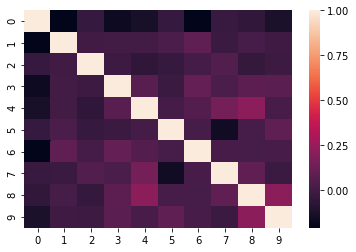

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [5]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


## My code goes here

In [14]:
# Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!
test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: %",total_variance*100)

paras_by_component = pd.DataFrame(test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: % 45.1889515490724
Component 0:
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Me ! oh !    0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !"        0.99929
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.675995
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbat

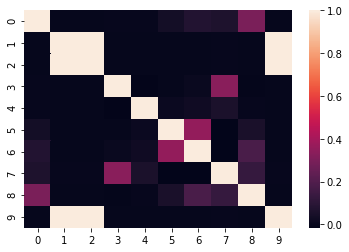

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [7]:
similarity2 = np.asarray(np.asmatrix(test_lsa) * np.asmatrix(test_lsa).T)
#Only taking the first 10 sentences
sim_matrix2=pd.DataFrame(similarity2,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix2,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix2.index[i])


## Tweaks go here

In [17]:
# new vectorizor
vectorizer2 = TfidfVectorizer(max_df=0.4, # drop words that occur in more than half the paragraphs
                             min_df=10, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

emma_paras_tfidf2=vectorizer2.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

X_train_tfidf2, X_test_tfidf2 = train_test_split(emma_paras_tfidf2, test_size=0.4, random_state=0)

X_train_tfidf_csr2 = X_train_tfidf2.tocsr()

n = X_train_tfidf_csr2.shape[0]
tfidf_bypara2 = [{} for _ in range(0,n)]
terms2 = vectorizer2.get_feature_names()
for i, j in zip(*X_train_tfidf_csr2.nonzero()):
    tfidf_bypara2[i][terms2[j]] = X_train_tfidf_csr2[i, j]

print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara2[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [18]:
#new vectorizer
X_train_lsa2 = lsa.fit_transform(X_train_tfidf2)

variance_explained2=svd.explained_variance_ratio_
total_variance2 = variance_explained2.sum()
print("Percent variance captured by all components:",total_variance2*100)

#Looking at what sorts of paragraphs our solution considers similar,
#for the first five identified topics
paras_by_component2=pd.DataFrame(X_train_lsa2,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component2.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 69.33634487981037
Component 0:
" Oh !     0.997662
" Oh !     0.997662
" Oh !     0.997662
" Oh !"    0.997662
" Oh !     0.997662
" Oh !     0.997662
" Oh !     0.997662
" Oh !     0.997662
" Oh !     0.997662
" Oh !     0.997662
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.700264
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.662712
Emma found that it was not Mr . Weston ' s fault that the number of privy councillors was not yet larger .                                                                  0.636854
Mr . Knightley might quarrel with her , but Emma could not quarrel with herself .                                                               

In [19]:
#new vectorizer
test_lsa2 = lsa.transform(X_test_tfidf2)

variance_explained2_test=svd.explained_variance_ratio_
total_variance2_test = variance_explained2_test.sum()
print("Percent variance captured by all components:",total_variance2_test*100)

paras_by_component2_test = pd.DataFrame(test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component2_test.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 69.33634487981037
Component 0:
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !         0.99929
" Me ! oh !    0.99929
" Oh !         0.99929
" Oh !         0.99929
" Oh !"        0.99929
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.675995
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbati

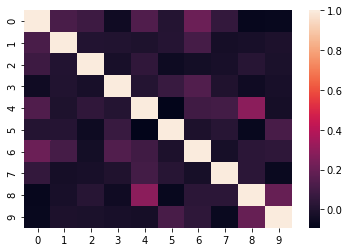

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [20]:
#new vectorizer
similarity2 = np.asarray(np.asmatrix(X_train_lsa2) * np.asmatrix(X_train_lsa2).T)
#Only taking the first 10 sentences
sim_matrix2=pd.DataFrame(similarity2,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix2,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix2.index[i])


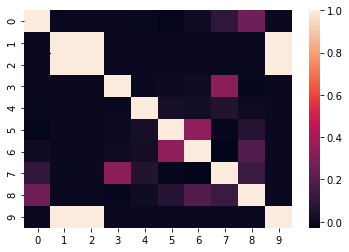

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [21]:
#new vectorizer
similarity2 = np.asarray(np.asmatrix(test_lsa2) * np.asmatrix(test_lsa2).T)
#Only taking the first 10 sentences
sim_matrix2=pd.DataFrame(similarity2,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix2,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix2.index[i])


First I record the settings as they are in the example. 

## Example model

We instantiated our model with the following settings in place:
max_df= .5 (to drop words that occur in more than half the paragraphs)
min_df= 2 ( to only keep words that occur at least twice)
stop_words= ‘english’
lowercase=True ( lowercase everything)
use_idf=True (use inverse document frequency in weighting)
norm= u’l2’ (long and short paragraphs get treated equally)
smooth_idf=True ( adds 1 to all doc frequencies to avoid divide by zero error)

With these settings the estimator returned 1948 features. 

The next step was to reduce the dimentionality. They chose to use Singular Value Decomposition, rather than PCA to avoid mean-centering the variables and losing sparsity. 

The variance captured by those components left is 45.176%

-Component 0 is in reference to the exclamation ‘Oh!’
-Component 1 is in reference to Emma being spoken to or speaking
-Component 2 is in reference to chapter labels
-Component 3 is in reference to the exclamation ‘Ah!’
-Component 4 is in reference to Emma speaking or acting directly

The similarity matrix shows only sentences 4&8, and 8&9 are similar.

### Running Test Data

The first challenge/drill/practice they had me do was to try to fitted estimator with the test data. I found:

The % variance captured is 45.189

-Component 0 is in reference to the exclamation ‘Oh!’
-Component 1 is in reference to Emma being spoken to or speaking
-Component 2 is in reference to chapter labels
-Component 3 is in reference to the exclamation ‘Ah!’
-Component 4 is in reference to Emma speaking or acting directly
 
The similarity matrix for the test set shows sentence 0 is little like 9, sentence 1 is like 2&9, and sentence 3 is little like sentence 7.

### Changing hyperparameters

I changed:
max_df to .65,
min_df to 5,
Everything else stayed the same.

After running the model again with the new hyper parameters, the feature numbers stayed the same, but the explained variance for the training set went up to 55.88%
-Component 0 is in reference to the exclamation ‘Oh!’
-Component 1 is in reference to Emma being spoken to or speaking
-Component 2 is in reference to chapter labels
-Component 3 switched from the exclamation ‘Ah!’ to Emma’s reactions or people speaking to her. 
-Component 4 changed to reference Mr.Knightley.

On the test set with new Hparams, the captured variance is still 55.88%

-Component 0 is in reference to the exclamation ‘Oh!’
-Component 1 seems to be about Emma and Mrs. Weston speaking or interacting
-Component 2 is in reference to chapter labels
-Component 3 is in reference to the exclamation ‘Ah!’
-Component 4 is more clearly about Emma.

The similarity matrix shows only sentence 8&4 and 8&9 as similar.
The similarity matrix for the test set shows only sentences 0&8 as mildly similar, 1&2 and 1&9 are similar and 2&9 are similar.


### Change Hyperparameters again

The next change is:
max_df to .4,
min_df to 10,
Everything else stayed the same.

The number of features stayed the same, but the captured variance went up to 69.336%

-Component 0 is in reference to the exclamation ‘Oh!’
-Component 1 seems to be about Emma and Mrs. Weston speaking or interacting
-Component 2 is chapter labels 
-Component 3 is now short sentences to do with Emma directly. 
-Component 4 is now about Mr. Knightley.

The captures variance for the test data rose to 69.336%.

-Components for the test data:
-Component 0 is in reference to the exclamation ‘Oh!’
-Component 1 seems to be about Mrs. Weston speaking or interacting
-Component 2 is in reference to chapter labels
-Component 3 is the exclamation ‘Ah!’ 
-Component 4 is about Emma speaking or reacting

The similarity in the training data only sentence 8&4 are similar. 

In the test data, sentences 0&8, and 7&3 are mildly similar. 
Sentences 1&2, and 1&9, and 2&9 are similar.